# Preparation of raw data for encoding task

__Contents:__
- <a href="#overview">Overview of the data set</a>
- <a href="#stim_check">Examining the stimulus data</a>
- <a href="#stim_ds">Spatially downsampling the stimulus</a>
- <a href="#resp_check">Examining the BOLD response data</a>
- <a href="#cleanidx_tr">Regarding pre-processing of responses</a>

___

We shall have two categorically distinct kinds of data: visual stimulus in the form of natural movies, and blood oxygen level-dependent (BOLD) signals measured using functional magnetic resonance imaging (fMRI), as an indicator of brain activity.

<img src="img/stimuli_ex.png" alt="Stimuli Image" width="240" height="180" />

<img src="img/fMRI_example.png" alt="fMRI Image" width="240" height="180" />

Our chief goal will be to create a working *encoder*, which predicts brain activity based on the contents of visual stimulus.

<a id="overview"></a>
## Overview of the data set

The data set of interest, called "Gallant Lab Natural Movie 4T fMRI Data set" (*vim-2*) contains the following types of data (of interest to us today):

__Stimuli__
```
Stimuli.tar.gz 4089110463 (3.8 GB)
```

__BOLD response__
```
VoxelResponses_subject1.tar.gz 3178624411 (2.9 GB)
VoxelResponses_subject2.tar.gz 3121761551 (2.9 GB)
VoxelResponses_subject3.tar.gz 3216874972 (2.9 GB)
```

All stimuli are stored in the *Stimuli.mat* file, Matlab v.7.3 format. Variables take the following forms.

 - *st:* training stimuli. 128x128x3x108000 matrix (108000 128x128 rgb frames). 
 - *sv:* validation stimuli. 128x128x3x8100 matrix (8100 128x128 rgb frames).

For the training data, stimulus was presented at 15 Hz over 7200 timepoints = 120 minutes, for a total of 108000 frames. For the validation data, stimulus was presented at 15 Hz over 540 timepoints = 9 minutes for a total of 8100 frames.

The validation stimulus was presented a total of ten times to each subject, and the response values used above correspond to the average taken over these trials. The "raw" validation response values (pre-averaging) are available, but the mean values serve our purposes just fine.

Finally, no re-arranging of the data is required, fortunately. The authors note:

> *"The order of the stimuli in the "st" and "sv" variables matches the order of the stimuli in the "rt" and "rv" variables in the response files."*

Moving forward, the first task is to decompress the data.

```
$ tar -xzf Stimuli.tar.gz
$ tar -xzf VoxelResponses_subject1.tar.gz
$ tar -xzf VoxelResponses_subject2.tar.gz
$ tar -xzf VoxelResponses_subject3.tar.gz
```

This leaves us with files *Stimuli.mat* and *VoxelResponses_subject{1,2,3}.mat*. Our key tool of use here will be the __PyTables__ library (http://www.pytables.org/usersguide/index.html), which is convenient for hierarchical data. To see what is stored in the data (and corroborate with the documentation), run the following.

```
$ ptdump Stimuli.mat
/ (RootGroup) ''
/st (EArray(108000, 3, 128, 128), zlib(3)) ''
/sv (EArray(8100, 3, 128, 128), zlib(3)) ''
```
Note the coordinates. There is not much of a hierarchy here, just two folders in the root group. Note the order of the dimensions; dim 1 is the observation index, dim 2 is the RGB channel, and dims 3 and 4 specify pixel position in an array.

The response data has a richer structure.

```
$ ptdump VoxelResponses_subject1.mat 
/ (RootGroup) ''
/rt (EArray(73728, 7200), zlib(3)) ''
/rv (EArray(73728, 540), zlib(3)) ''
/rva (EArray(73728, 10, 540), zlib(3)) ''
(...Warnings...)
/ei (Group) ''
/ei/TRsec (Array(1, 1)) ''
/ei/datasize (Array(3, 1)) ''
/ei/imhz (Array(1, 1)) ''
/ei/valrepnum (Array(1, 1)) ''
/roi (Group) ''
/roi/FFAlh (EArray(18, 64, 64), zlib(3)) ''
/roi/FFArh (EArray(18, 64, 64), zlib(3)) ''
/roi/IPlh (EArray(18, 64, 64), zlib(3)) ''
/roi/IPrh (EArray(18, 64, 64), zlib(3)) ''
/roi/MTlh (EArray(18, 64, 64), zlib(3)) ''
/roi/MTplh (EArray(18, 64, 64), zlib(3)) ''
/roi/MTprh (EArray(18, 64, 64), zlib(3)) ''
/roi/MTrh (EArray(18, 64, 64), zlib(3)) ''
/roi/OBJlh (EArray(18, 64, 64), zlib(3)) ''
/roi/OBJrh (EArray(18, 64, 64), zlib(3)) ''
/roi/PPAlh (EArray(18, 64, 64), zlib(3)) ''
/roi/PPArh (EArray(18, 64, 64), zlib(3)) ''
/roi/RSCrh (EArray(18, 64, 64), zlib(3)) ''
/roi/STSrh (EArray(18, 64, 64), zlib(3)) ''
/roi/VOlh (EArray(18, 64, 64), zlib(3)) ''
/roi/VOrh (EArray(18, 64, 64), zlib(3)) ''
/roi/latocclh (EArray(18, 64, 64), zlib(3)) ''
/roi/latoccrh (EArray(18, 64, 64), zlib(3)) ''
/roi/v1lh (EArray(18, 64, 64), zlib(3)) ''
/roi/v1rh (EArray(18, 64, 64), zlib(3)) ''
/roi/v2lh (EArray(18, 64, 64), zlib(3)) ''
/roi/v2rh (EArray(18, 64, 64), zlib(3)) ''
/roi/v3alh (EArray(18, 64, 64), zlib(3)) ''
/roi/v3arh (EArray(18, 64, 64), zlib(3)) ''
/roi/v3blh (EArray(18, 64, 64), zlib(3)) ''
/roi/v3brh (EArray(18, 64, 64), zlib(3)) ''
/roi/v3lh (EArray(18, 64, 64), zlib(3)) ''
/roi/v3rh (EArray(18, 64, 64), zlib(3)) ''
/roi/v4lh (EArray(18, 64, 64), zlib(3)) ''
/roi/v4rh (EArray(18, 64, 64), zlib(3)) ''

```

Within the root group, we have arrays `rt`, `rv`, and `rva` which contain BOLD response data, group `roi` which contains arrays used as indices for assigning particular responses to particular voxels, and group `ei` which stores pertinent experimental information. In particular, under the `roi` group there are numerous arrays named according to anatomical/functional regions of interest (ROI). For example, `v4rh` corresponds to the __V4__ region in the __l__eft __h__emisphere. Since there are far less ROIs than there are voxels $18 \times 64 \times 64 = 73728$, note that each region is composed of many voxels.

<a id="stim_check"></a>
## Examining the stimulus data

Let's begin by taking a look inside the stimulus.

In [1]:

import numpy as np
import tables
import matplotlib
from matplotlib import pyplot as plt
import pprint as pp

# Open file connection.
f = tables.open_file("data/vim-2/Stimuli.mat", mode="r")

# Get object and array.
stimulus_object = f.get_node(where="/", name="sv")
print("stimulus_object:")
print(stimulus_object)
print(type(stimulus_object))
print("----")

stimulus_array = stimulus_object.read()
print("stimulus_array:")
#print(stimulus_array)
print(type(stimulus_array))
print("----")

# Close the connection.
f.close()

# Check that it is closed.
if not f.isopen:
    print("Successfully closed.")
else:
    print("File connection is still open.")


stimulus_object:
/sv (EArray(8100, 3, 128, 128), zlib(3)) ''
<class 'tables.earray.EArray'>
----
stimulus_array:
<class 'numpy.ndarray'>
----
Successfully closed.


Let's inspect the content of this array to ensure it has the content that we expect.

stimulus_object:
/sv (EArray(8100, 3, 128, 128), zlib(3)) ''
<class 'tables.earray.EArray'>
----
stimulus_array:
(type)
<class 'numpy.ndarray'>
(dtype)
uint8
----


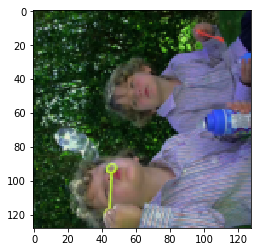

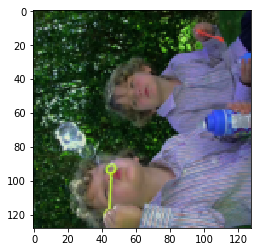

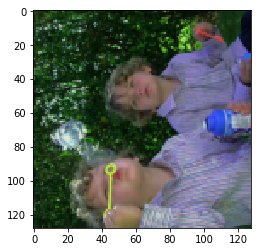

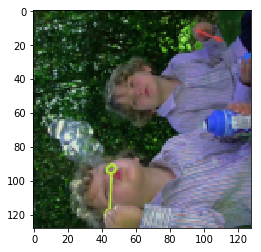

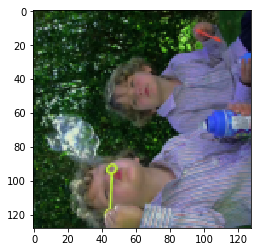

In [2]:
# Open file connection.
f = tables.open_file("data/vim-2/Stimuli.mat", mode="r")

# Get object and array.
stimulus_object = f.get_node(where="/", name="sv")
print("stimulus_object:")
print(stimulus_object)
print(type(stimulus_object))
print("----")

stimulus_array = stimulus_object.read()
print("stimulus_array:")
#print(stimulus_array)
print("(type)")
print(type(stimulus_array))
print("(dtype)")
print(stimulus_array.dtype)
print("----")

num_frames = stimulus_array.shape[0]
num_channels = stimulus_array.shape[1]
frame_w = stimulus_array.shape[2]
frame_h = stimulus_array.shape[3]

frames_to_play = 5

oneframe = np.zeros(num_channels*frame_h*frame_w, dtype=np.uint8).reshape((frame_h, frame_w, num_channels))
im = plt.imshow(oneframe)

for t in range(frames_to_play):
    oneframe[:,:,0] = stimulus_array[t,0,:,:] # red
    oneframe[:,:,1] = stimulus_array[t,1,:,:] # green
    oneframe[:,:,2] = stimulus_array[t,2,:,:] # blue
    plt.imshow(oneframe)
    plt.show()

f.close()


To actually view this as a video, execute the following script from the command line (assuming the current directory is `learnml`).

```
$ cd scripts
$ python vidcheck1.py
```

The reason for this is simply because there is a bug in matplot lib (https://github.com/matplotlib/matplotlib/pull/9415) such that pausing doesn't work as it should.

Anyways, clearly the content is roughly as we would expect (a series of video clips), although the orientation is incorrect, and the framerate is rather high.


### Exercises (A):

0. Swap the coordinates (see help(np.swapaxes)) to fix the orientation.

0. In addition to the first handful of frames, check the *last* handful of frames to ensure that the content is as we expect.

0. Repeat the visualization procedure above for `st` (the training data) to ensure it is also as we expect.

0. Do the above procedures for the first 100 frames. Note that the current framerate is 15Hz. By modifying the `for` loop above, using `np.arange` instead of `range`, we can easily "down-sample" to a lower temporal frequency. Try downsampling to a rate of 1Hz (by displaying one out of every fifteen frames).
___

<a id="stim_ds"></a>
## Spatially downsampling the stimulus

For computational purposes, it is advisable to spatially down-sample the stimulus data, in addition to the temporal down-sampling required to align it with the BOLD signal responses (this can be done later). Here we carry out the spatial down-sampling. Using the function `resize` from the `transform` module of __scikit-image__, this can be done easily. First, a simple test.

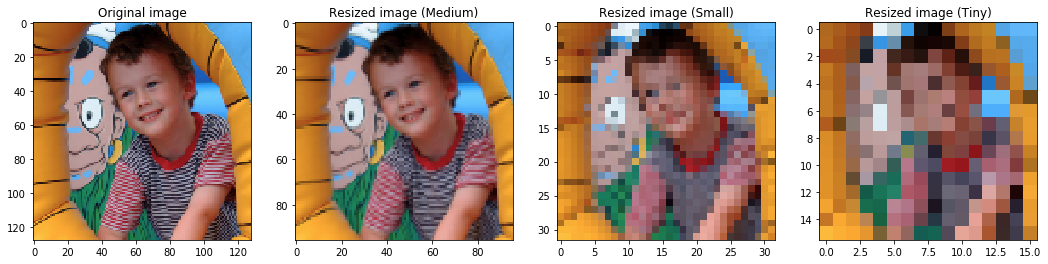

In [3]:
from skimage import transform as trans
import imageio

im = imageio.imread("img/bishop.png") # a 128px x 128px image

med_h = 96 # desired height in pixels
med_w = 96 # desired width in pixels
im_med = trans.resize(image=im, output_shape=(med_h,med_w), mode="reflect")

small_h = 32 # desired height in pixels
small_w = 32 # desired width in pixels
im_small = trans.resize(image=im, output_shape=(small_h,small_w), mode="reflect")

tiny_h = 16 # desired height in pixels
tiny_w = 16 # desired width in pixels
im_tiny = trans.resize(image=im, output_shape=(tiny_h,tiny_w), mode="reflect")

myfig = plt.figure(figsize=(18,4))

ax_im = myfig.add_subplot(1,4,1)
plt.imshow(im)
plt.title("Original image")
ax_med = myfig.add_subplot(1,4,2)
plt.imshow(im_med)
plt.title("Resized image (Medium)")
ax_small = myfig.add_subplot(1,4,3)
plt.imshow(im_small)
plt.title("Resized image (Small)")
ax_small = myfig.add_subplot(1,4,4)
plt.imshow(im_tiny)
plt.title("Resized image (Tiny)")

plt.show()


Everything appears to be working as expected. Let us now do this for the entire set of visual stimulus.

In [4]:
# Open file connection.
f = tables.open_file("data/vim-2/Stimuli.mat", mode="r")

# Get object and array.
stimulus_object = f.get_node(where="/", name="sv")
stimulus_array = stimulus_object.read()
num_frames = stimulus_array.shape[0]
num_channels = stimulus_array.shape[1]

# Swap the axes.
print("stimulus array (before):", stimulus_array.shape)
stimulus_array = np.swapaxes(a=stimulus_array, axis1=0, axis2=3)
stimulus_array = np.swapaxes(a=stimulus_array, axis1=1, axis2=2)
print("stimulus array (after):", stimulus_array.shape)

# Downsampled height and width.
ds_h = 96
ds_w = 96

stimulus_array_ds = np.zeros(num_frames*num_channels*ds_h*ds_w,\
                             dtype=np.float32).reshape((ds_h, ds_w, num_channels, num_frames))

for t in range(num_frames):
    stimulus_array_ds[:,:,:,t] = trans.resize(image=stimulus_array[:,:,:,t],
                                              output_shape=(ds_h,ds_w),
                                              mode="reflect")
    if t % 500 == 0:
        print("Update: t =", t)
        
f.close()

stimulus array (before): (8100, 3, 128, 128)
stimulus array (after): (128, 128, 3, 8100)
Update: t = 0
Update: t = 500
Update: t = 1000
Update: t = 1500
Update: t = 2000
Update: t = 2500
Update: t = 3000
Update: t = 3500
Update: t = 4000
Update: t = 4500
Update: t = 5000
Update: t = 5500
Update: t = 6000
Update: t = 6500
Update: t = 7000
Update: t = 7500
Update: t = 8000


Note that resizing the images yields pixel values on $[0,1]$ rather than $\{0,1,\ldots,255\}$, which is why we set the *dtype* to *np.float32*.

In [5]:
print("(Pre-downsize) max:", np.max(stimulus_array),
      "min:", np.min(stimulus_array),
      "ave:", np.mean(stimulus_array))
print("(Post-downsize) max:", np.max(stimulus_array_ds),
      "min:", np.min(stimulus_array_ds),
      "ave:", np.mean(stimulus_array_ds))

(Pre-downsize) max: 255 min: 0 ave: 90.5094239185
(Post-downsize) max: 1.0 min: 0.0 ave: 0.354924


Let's now save this as a binary file for fast reading/writing.

In [6]:
fname = "data/vim-2/X_te.dat"
dtype = stimulus_array_ds.dtype
shape = stimulus_array_ds.shape
with open(fname, mode="bw") as fbin:
    stimulus_array_ds.tofile(fbin)
    print("Saved to file.")

Saved to file.


To ensure that everything worked as desired, load it up and look at the first few frames.

Reading... OK.


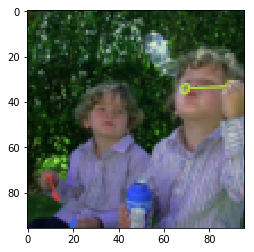

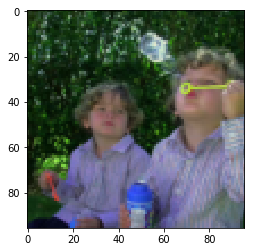

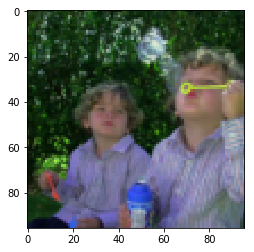

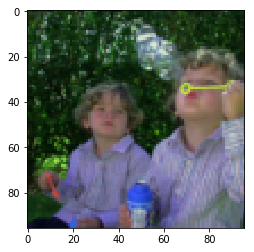

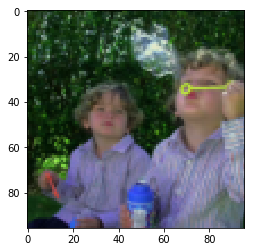

In [7]:

# Wipe the downsampled array.
stimulus_array_ds = np.zeros(num_frames*num_channels*ds_h*ds_w,\
                             dtype=np.float32).reshape((ds_h, ds_w, num_channels, num_frames))

# Load up the stored array.
with open(fname, mode="br") as fbin:
    print("Reading...", end=" ")
    stimulus_array_ds = np.fromfile(file=fbin, dtype=dtype).reshape(shape)
    print("OK.")

# Check a few frames.
num_frames = stimulus_array_ds.shape[3]

frames_to_play = 5

for t in range(frames_to_play):
    plt.imshow(stimulus_array_ds[:,:,:,t])
    plt.show()


### Exercises (B):

0. Repeat the above down-sampling and writing to disk for `st`, the training data, saving this as `X_tr` (as a companion to `X_te` saved above).

0. For potential investigation later on, prepare a *very* small version of the stimulus, say $32 \times 32$ pixels, saved using the names `X_tr_32px` and `X_tr_32px`. What do you think the potential benefits are of doing this? What about potential drawbacks?

___


<a id="resp_check"></a>
## Examining the BOLD response data

Next, we examine the response data (feel free to reset the kernel here).

In [1]:
import numpy as np
import tables
import matplotlib
from matplotlib import pyplot as plt
import pprint as pp

# Open file connection.
f = tables.open_file("data/vim-2/VoxelResponses_subject1.mat", mode="r")

# Get objects and arrays.

response_object = f.get_node(where="/", name="rv")
idx_object = f.get_node(where="/roi/", name="v4lh")

print("response_object:")
print(response_object)
print(type(response_object))
print("----")
print("idx_object:")
print(idx_object)
print(type(idx_object))
print("----")

response_array = response_object.read()
idx_array = idx_object.read()

print("response_array:")
#print(response_array)
print(type(response_array))
print("----")
print("idx_array:")
#print(idx_array)
print(type(idx_array))
print("----")

# Close the connection.
f.close()

# Check that it is closed.
if not f.isopen:
    print("Successfully closed.")
else:
    print("File connection is still open.")


response_object:
/rv (EArray(73728, 540), zlib(3)) ''
<class 'tables.earray.EArray'>
----
idx_object:
/roi//v4lh (EArray(18, 64, 64), zlib(3)) ''
<class 'tables.earray.EArray'>
----


/home/mjh/anaconda3/lib/python3.6/site-packages/tables/attributeset.py:299: DataTypeWarning: Unsupported type for attribute 'MATLAB_fields' in node ''. Offending HDF5 class: 9
  value = self._g_getattr(self._v_node, name)


response_array:
<class 'numpy.ndarray'>
----
idx_array:
<class 'numpy.ndarray'>
----
Successfully closed.


Let's examine the contents of a particular index array.

In [2]:

pp.pprint(idx_array[0:2, 0:5,0:5])
print("dtype:", idx_array.dtype)
print("unique:", np.unique(idx_array))
print("sum =", np.sum(idx_array))


array([[[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]]])
dtype: float64
unique: [ 0.  1.]
sum = 308.0


It is clear that we can just sum these indicators to check how many voxels there are in each ROI.

### Exercises (C):

0. Use `np.nonzero` to get the actual indices that are "hot".

0. How many voxels are there in the ROI called V4 in the left hemisphere?

0. How many voxels are in V4 in total? (both left and right hemispheres)

0. Is this number the same across all subjects?

0. Check that the sum of all the contents of all the index matrices indeed equals the total number of voxels, known *a priori* to be 73728.

0. Plot a histogram of bin counts (see *numpy.histogram*) for each region. Which region is largest? Smallest? Is there a difference between left/right hemispheres, or are they symmetric?
___

Now that we have an idea what the index does, let's examine the actual response values for a few voxels over the first couple minutes of observations.

shape: (308, 540)
sum of index: 308.0
dtype: float32
num of nans: 0
dtype: float32
num of nans: 0
dtype: float32
num of nans: 0
dtype: float32
num of nans: 0


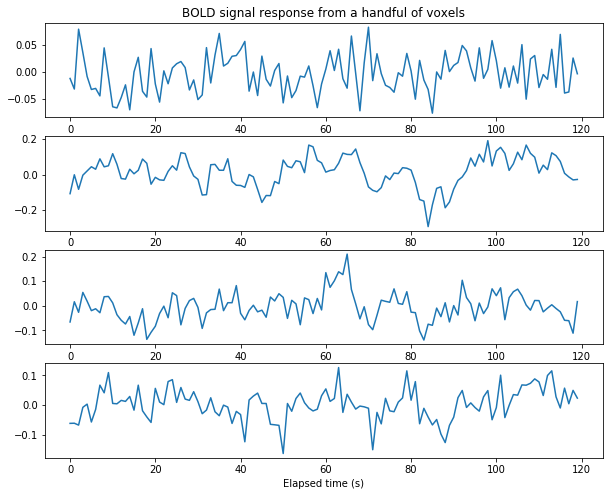

In [3]:
# Open file connection.
with tables.open_file("data/vim-2/VoxelResponses_subject1.mat", mode="r") as f:
    
    idx_object_myroi = f.get_node(where="/roi/", name="v4lh")
    idx_array_myroi = idx_object_myroi.read()
    
    indices = np.nonzero(idx_array_myroi.flatten())[0] # returns a tuple; extract the array.
    response_myroi = np.take(a=response_array, axis=0, indices=indices)
    print("shape:", response_myroi.shape)
    print("sum of index:", np.sum(idx_array_myroi))
    
num_secs = 120
time_idx = np.arange(0, num_secs, 1)

myfig = plt.figure(figsize=(10,8))

myfig.add_subplot(4,1,1)
plt.title("BOLD signal response from a handful of voxels")
val = response_myroi[0,time_idx]
plt.plot(time_idx, val)
print("dtype:", val.dtype)
print("num of nans:", np.sum(np.isnan(val)))

myfig.add_subplot(4,1,2)
val = response_myroi[1,time_idx]
plt.plot(time_idx, val)
print("dtype:", val.dtype)
print("num of nans:", np.sum(np.isnan(val)))

myfig.add_subplot(4,1,3)
val = response_myroi[2,time_idx]
plt.plot(time_idx, val)
print("dtype:", val.dtype)
print("num of nans:", np.sum(np.isnan(val)))

myfig.add_subplot(4,1,4)
val = response_myroi[3,time_idx]
plt.plot(time_idx, val)
print("dtype:", val.dtype)
print("num of nans:", np.sum(np.isnan(val)))

plt.xlabel("Elapsed time (s)")
plt.show()


The responses are rather erratic, but at least appear to be correctly read. The main issue that we run into here is the existence of *missing values*.

To find the bad voxels is not difficult, as demonstrated below.

In [4]:

num_voxels = response_array.shape[0]
cleanidx = np.zeros((num_voxels,), dtype=np.uint32)

# Loop over the response array.
for v in range(num_voxels):
    
    if np.sum(np.isnan(response_array[v,:])) == 0:
        cleanidx[v] = 1 # on if the voxel is clean, otherwise off.

num_good = np.sum(cleanidx)
num_bad = np.int(num_voxels-num_good)
print("total good =", num_good, ";", format(100*num_good/num_voxels, ".2f"), "percent.")
print("total bad =", num_bad, ";", format(100*num_bad/num_voxels, ".2f"), "percent.")


with open("data/vim-2/cleanidx_te.dat", mode="bw") as fbin:
    cleanidx.tofile(fbin)
    print("Saved to file.")
    

total good = 63050 ; 85.52 percent.
total bad = 10678 ; 14.48 percent.
Saved to file.


It should be clear that most of the voxels have no missing values.

### Exercises (D):

0. Compare the first 120 seconds of the first four voxels of `v1lh`, with those of `v4lh`. Note that the former ROI has voxels with missing values; the usual placeholder for these is `nan`.

0. How many voxels have missing values on the training data? Make a histogram of with counts of "bad" voxels for each ROI. Are some regions more prone to missing values than others? Is there much difference between the left and right hemispheres of the same ROIs?

0. Store the "clean indices" for the training data (call it `cleanidx_tr`) in addition to that for the testing data. Since we will in the end only want to train a model for voxels with both training and testing observations available, compute the intersection of `cleanidx_tr` and `cleanidx_te`, and save this as simply `cleanidx`.

___

As with the input data, let us save the response data in a form that is quickly readable.

In [5]:

fname = "data/vim-2/y_te.dat"
dtype = response_array.dtype
shape = response_array.shape
with open(fname, mode="bw") as fbin:
    response_array.tofile(fbin)
    print("Saved to file.")
    

Saved to file.


To ensure that the data is as we expect after saving it to file, let's read it, re-shape it, and visualize.

Reading... OK.
dtype: float32
num of nans: 0
dtype: float32
num of nans: 0
dtype: float32
num of nans: 0
dtype: float32
num of nans: 0


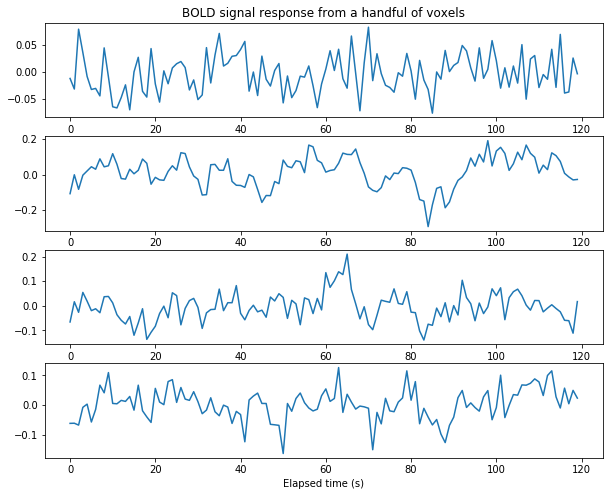

In [6]:
# Wipe the response array.
response_array = np.zeros(response_array.size, dtype=response_array.dtype).reshape(response_array.shape)

# Load up the stored array.
with open(fname, mode="br") as fbin:
    print("Reading...", end=" ")
    response_array = np.fromfile(file=fbin, dtype=dtype).reshape(shape)
    print("OK.")

# Do the exact same visualization, and see if things change.    
num_secs = 120
time_idx = np.arange(0, num_secs, 1)

myfig = plt.figure(figsize=(10,8))

myfig.add_subplot(4,1,1)
plt.title("BOLD signal response from a handful of voxels")
val = response_myroi[0,time_idx]
plt.plot(time_idx, val)
print("dtype:", val.dtype)
print("num of nans:", np.sum(np.isnan(val)))

myfig.add_subplot(4,1,2)
val = response_myroi[1,time_idx]
plt.plot(time_idx, val)
print("dtype:", val.dtype)
print("num of nans:", np.sum(np.isnan(val)))

myfig.add_subplot(4,1,3)
val = response_myroi[2,time_idx]
plt.plot(time_idx, val)
print("dtype:", val.dtype)
print("num of nans:", np.sum(np.isnan(val)))

myfig.add_subplot(4,1,4)
val = response_myroi[3,time_idx]
plt.plot(time_idx, val)
print("dtype:", val.dtype)
print("num of nans:", np.sum(np.isnan(val)))

plt.xlabel("Elapsed time (s)")
plt.show()

Comparing the figure just produced with the one based on the original data, they clearly look identical, assuming everything was done correctly.

### Exercises (E):

0. Prepare `y_tr` using `rt` in a manner completely analogous to `y_te` using `rv` above.

0. As practice with basic plotting tools, create a figure composed of 8 plots, in a 4 x 2 (4 rows, two columns) format, with the following content. Choose four "clean" voxels from the training data, in the ROI called V1, where both left and right hemispheres have no missing data. These voxels correspond to the four rows. The columns correspond to the left and right hemispheres respectively (for a total of 8 voxels, one voxel per plot). The content of each plot is simply the first 60 seconds of measured activity.

0. Finally, the clean indices and response computations above have only been computed for a single subject. Carry out the above procedures for each separate subject, perhaps appending `sub1`, `sub2`, `sub3` etc. to the filenames. For example, instead of a single non-specific `y_tr.dat`, we should have `y_tr_sub1.dat`, `y_tr_sub2.dat`, `y_tr_sub3.dat`, and so forth for the `X_tr`, `X_te`, `y_te` as well.

___

<a id="resp_pproc"></a>
## Regarding pre-processing of responses

Now, raw BOLD signals typically require some pre-processing. Fortunately, that work has been essentially done for us. To confirm this, let's check the documentation again. Quoting from the *vim-2* dataset description file,

> *"The functional data were collected for three subjects, in three sessions over three separate days for each subject (please see the Nishimoto et al. 2011 for scanning and preprocessing parameters). Peak BOLD responses to each timepoint in the stimuli were estimated from the preprocessed data."*

This tells us that we do not need to mess around with the response values. For reference, to unpack the pre-processing that was used to estimate peak BOLD responses, they provide a lucid description in the appendix of the cited paper (*Supplemental Experimental Procedures -- Data Preprocessing*):

> *"BOLD signals were preprocessed as described in earlier publications. Briefly, motion compensation was performed using SPM '99, and supplemented by additional custom algorithms. For each 10 minute run and each individual voxel, drift in BOLD signals was first removed by fitting a third-degree polynomial, and signals were then normalized to mean 0.0 and standard deviation 1.0."*

To be clear, the peak response estimates are *based* on data that was pre-processed as above. It is *not* the case that the final per-block estimates themselves have been normalized in this fashion. That said, it is easily confirmed that the sample mean and standard deviation of each 10-minute block (of the training data) is approximately centered and with unit variance:

In [9]:

# Load up the training data.
fname = "data/vim-2/y_tr.dat"
with open(fname, mode="br") as fbin:
    print("Reading...", end=" ")
    response_array = np.fromfile(file=fbin, dtype=np.float32).reshape((73728, 7200))
    print("OK.")
    
fname = "data/vim-2/cleanidx_tr.dat"
with open(fname, mode="br") as fbin:
    print("Reading...", end=" ")
    cleanidx_tr = np.fromfile(file=fbin, dtype=np.uint32)
    print("OK.")
    
response_array_clean = np.take(a=response_array, axis=0, indices=np.nonzero(cleanidx_tr)[0])

voxel_idx = 0 # the (clean) voxel idx to check
tmpspan = 600 # 10 minute "blocks"; units are seconds.
for i in range(response_array_clean.shape[1]//tmpspan):
    tmpi = i
    tmpidx = np.arange((tmpi*tmpspan), (tmpi+1)*tmpspan)
    response_tocheck = response_array_clean[voxel_idx,tmpidx]
    print("Block num =", i, ", mean =", np.mean(response_tocheck), ", std =", np.std(response_tocheck))


Reading... OK.
Reading... OK.
Block num = 0 , mean = 0.0156803 , std = 1.00459
Block num = 1 , mean = 0.00736417 , std = 1.00138
Block num = 2 , mean = -0.00962033 , std = 0.988261
Block num = 3 , mean = -0.0175966 , std = 1.00064
Block num = 4 , mean = 0.00608314 , std = 1.01073
Block num = 5 , mean = 6.8992e-05 , std = 0.996459
Block num = 6 , mean = 0.000770969 , std = 1.00274
Block num = 7 , mean = 0.00467389 , std = 0.999116
Block num = 8 , mean = -0.0125333 , std = 0.988603
Block num = 9 , mean = 0.0116375 , std = 1.01514
Block num = 10 , mean = 0.00888207 , std = 1.00319
Block num = 11 , mean = 0.0399806 , std = 0.993143


### End of lesson: paste any routines to be re-used in the `scripts/vim-2.py` file.

## References:

 - Nishimoto, Shinji, et al. "Reconstructing visual experiences from brain activity evoked by natural movies." Current Biology 21.19 (2011): 1641-1646.
 - Description of dataset vim-2 (visual imaging 2), at CRCNS - Collaborative Research in Computational Neuroscience. https://crcns.org/data-sets/vc/vim-2/about-vim-2